<h1>FAISS<h1>
<h5>We implement the FAISS, a similarity search algortihm developed by Facebook. In this notebook, we use the dataset with cleaned tweets as the input and training dataset<h5>

In [2]:
#import libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from string2string.search import FaissSearch
import dill

In [3]:
#import datasets with cleaned tweets
train_df = pd.read_pickle('./train_df_cleaned.pkl')
test_df = pd.read_pickle('./test_df_cleaned.pkl')

In [4]:
#helper function to generate performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    print(thresholds)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#The below code is used to create a few shot corpus by selecting 50 (or 25) examples each from both class. Once generated its saved as a pickle file
'''positive_examples = train_df[train_df['related_manual']==1].head(50)
negative_examples = train_df[train_df['related_manual']==0].head(50)
fewshot_df = pd.concat([positive_examples,negative_examples])
fewshot_df.to_pickle('./fewshot_df_100.pkl')'''

In [5]:
fewshot_df_100 = pd.read_pickle('./fewshot_df_100_cleaned.pkl')

In [6]:
fewshot_df_50 = pd.read_pickle('./fewshot_df_50_cleaned.pkl')

<h2>50 examples<h2>

<h5>First we experiment with 50 examples (25 from each class). We also try to study the model's performance w.r.t the two embedding types. mean pooling and last hidden state.

In [7]:
#initialise faiss model (embedding - mean pooling, number of samples - 50)
faiss_search_mean_50 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [8]:
corpus_50 = {'text':fewshot_df_50['tweet_preprocessed']}

In [9]:
#initialising the search corpus using the fewshot dataset which we generated
%%time
faiss_search_mean_50.initialize_corpus(
    corpus=corpus_50,
    section='text', 
    embedding_type='mean_pooling',
    )

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 13.1 s, total: 2min 55s
Wall time: 21.7 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 50
})

In [10]:
#helper function to perform faiss prediction
def faiss_predict(tweet, model, dataset):
    query = tweet  #tweet to be classified
    top_k=3       
    top_k_results = model.search(query=query, k = top_k)  #select top 3 similar tweets
    top_matching_tweet = top_k_results['text'][0] #select the most similar tweet from them
    idx = dataset.index[dataset['tweet_preprocessed']==top_matching_tweet][0] #find the index of the most similar tweet from the corpus
    return dataset['related_manual'][idx] #return the most similar tweets class

In [11]:
#faiss prediction
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'meanpooling_50'] = faiss_predict(item['tweet_preprocessed'], faiss_search_mean_50, fewshot_df_50)

CPU times: user 26min 41s, sys: 1min 20s, total: 28min 2s
Wall time: 5min 32s


Accuracy: 71.4%
[179  71  72 178]
TP: 179
FP: 72
TN: 178
FN: 71
Sensitivity: 71.6%
Specificity: 71.2%
Precision: 71.315%
Recall: 71.6%
f1: 71.457%


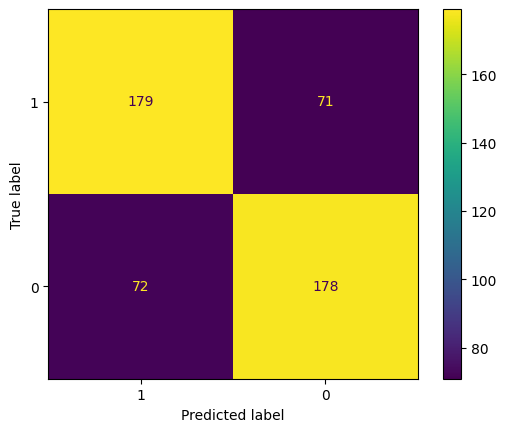

[inf  1.  0.]


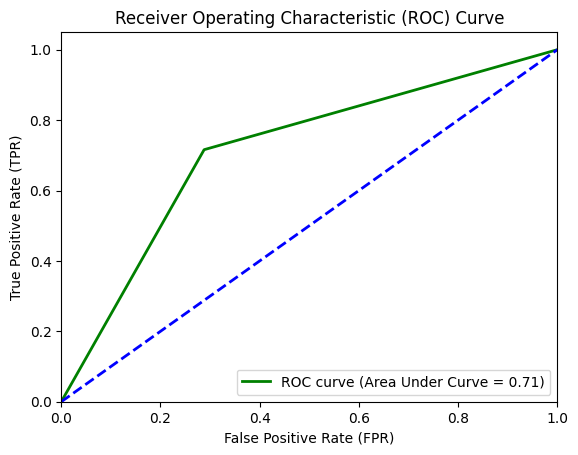

In [12]:
#performance report
performance(test_df['related_manual'],test_df['meanpooling_50'])

In [13]:
#initialise faiss model (embedding - last hidden state, number of samples - 50)
faiss_search_lh_50 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [14]:
#initialise corpus, by default last hidden state is used
%%time
faiss_search_lh_50.initialize_corpus(
    corpus=corpus_50,
    section='text'
    )

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 48s, sys: 16.2 s, total: 3min 4s
Wall time: 23.6 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 50
})

In [15]:
#faiss prediction
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'lh_50'] = faiss_predict(item['tweet_preprocessed'], faiss_search_lh_50, fewshot_df_50)

CPU times: user 27min 1s, sys: 1min 28s, total: 28min 30s
Wall time: 2min 39s


Accuracy: 56.8%
[146 104 112 138]
TP: 146
FP: 112
TN: 138
FN: 104
Sensitivity: 58.4%
Specificity: 55.2%
Precision: 56.589%
Recall: 58.4%
f1: 57.48%


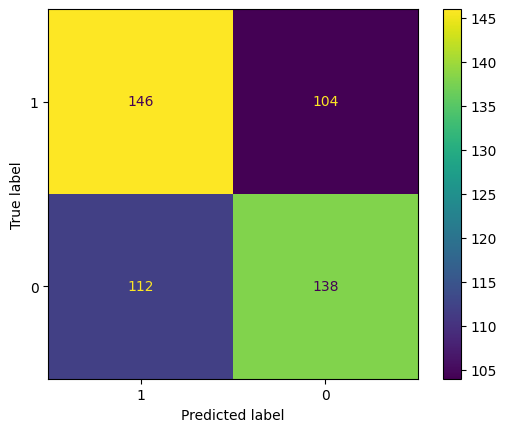

[inf  1.  0.]


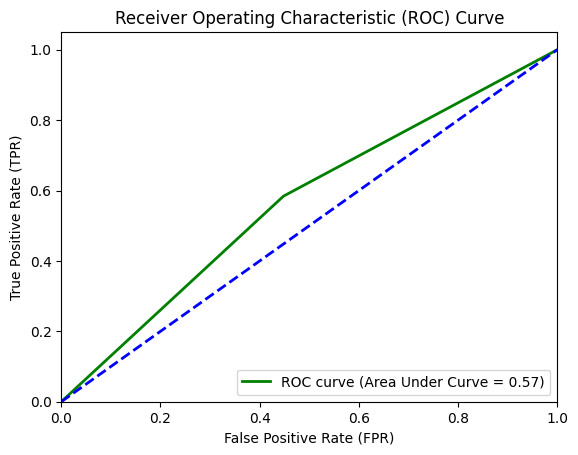

In [16]:
#performance report
performance(test_df['related_manual'],test_df['lh_50'])

<h2>100 examples<h2>

<h5> Now lets repeat the same experiment with 100 examples (50 from each class)

In [17]:
#initialise faiss model (embedding - mean pooling, number of samples - 100)
faiss_search_mean_100 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [18]:
corpus_100 = {'text':fewshot_df_100['tweet_preprocessed']}

In [19]:
#initialise corpus
%%time
faiss_search_mean_100.initialize_corpus(
    corpus=corpus_100,
    section='text', 
    embedding_type='mean_pooling',
    )

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5min 29s, sys: 24.7 s, total: 5min 54s
Wall time: 39.4 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 100
})

In [20]:
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'meanpooling_100'] = faiss_predict(item['tweet_preprocessed'], faiss_search_mean_100, fewshot_df_100)

CPU times: user 27min 7s, sys: 1min 21s, total: 28min 28s
Wall time: 2min 37s


Accuracy: 73.8%
[170  80  51 199]
TP: 170
FP: 51
TN: 199
FN: 80
Sensitivity: 68.0%
Specificity: 79.6%
Precision: 76.923%
Recall: 68.0%
f1: 72.187%


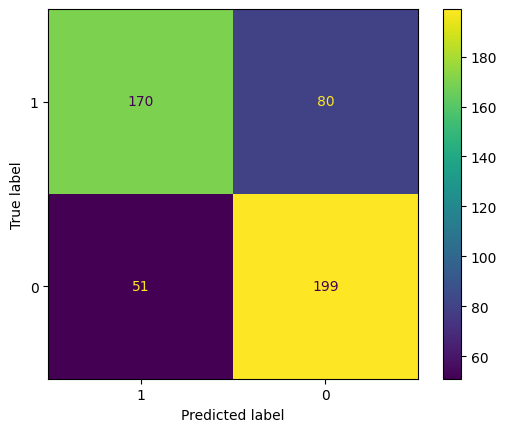

[inf  1.  0.]


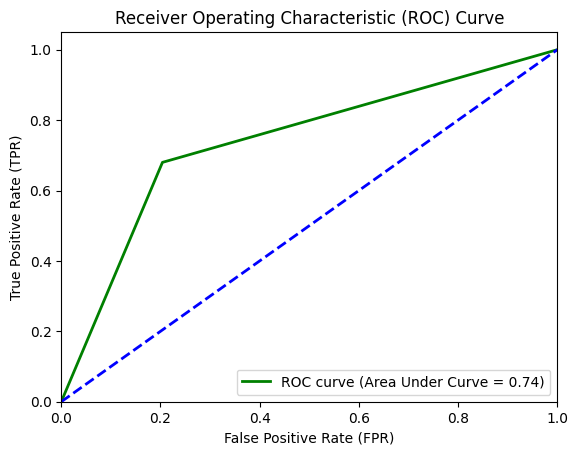

In [21]:
performance(test_df['related_manual'],test_df['meanpooling_100'])

In [22]:
#initialise faiss model (embedding - last hidden state, number of samples - 100)
faiss_search_lh_100 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [23]:
%%time
faiss_search_lh_100.initialize_corpus(
    corpus=corpus_100,
    section='text'
    )

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5min 21s, sys: 21.9 s, total: 5min 43s
Wall time: 38.4 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 100
})

In [24]:
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'lh_100'] = faiss_predict(item['tweet_preprocessed'], faiss_search_lh_100, fewshot_df_100)

CPU times: user 26min 42s, sys: 1min 27s, total: 28min 10s
Wall time: 2min 37s


Accuracy: 54.4%
[137 113 115 135]
TP: 137
FP: 115
TN: 135
FN: 113
Sensitivity: 54.8%
Specificity: 54.0%
Precision: 54.365%
Recall: 54.8%
f1: 54.582%


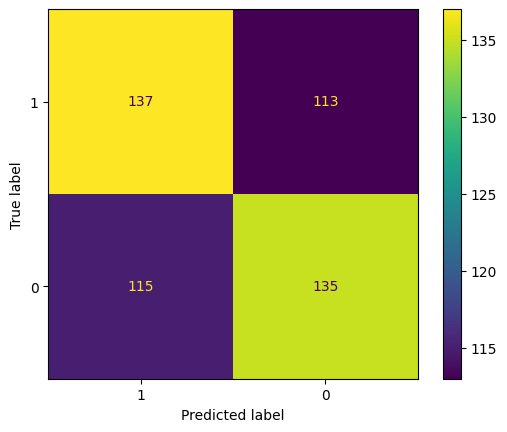

[inf  1.  0.]


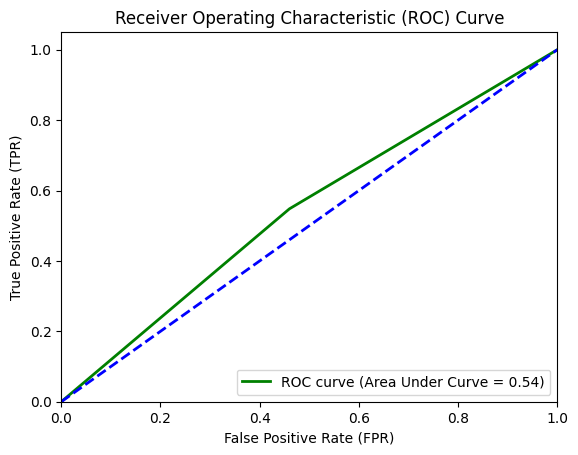

In [25]:
performance(test_df['related_manual'],test_df['lh_100'])

<h2>Results<h2>
<h5>The best performing model is the one which is trained with 100 examples and embedding type is mean pooling.

| Model            | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|------------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| Few shot (Faiss) | 73.8%    | 170 | 51 | 199 | 80 | 68.0%       | 79.6%       | 76.923%   | 68.0%  | 72.187%  |